<a href="https://colab.research.google.com/github/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/blob/main/Drivers_Behavior_Detection_with_Smartphone_Signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Driver Behavior Detection with Smartphone Signal Processing

## Project Architecture

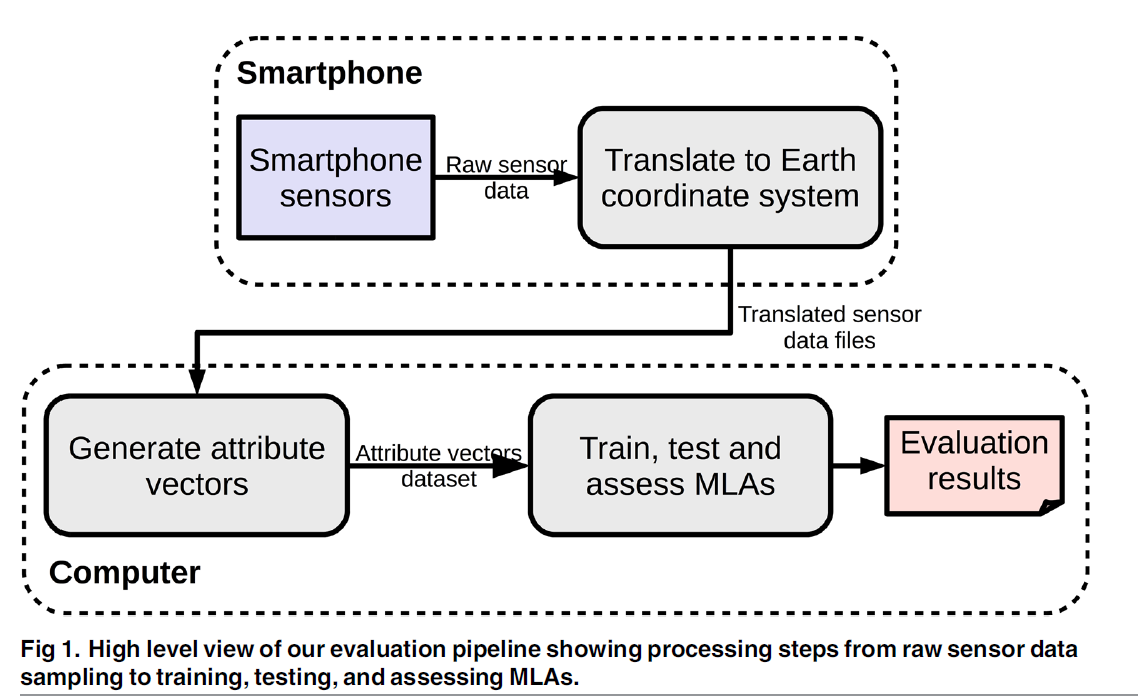

# Loading Data

Source:
- https://data.mendeley.com/datasets/5stn873wft/1
- S. Nazirkar, “Phone sensor data while driving a car and normal or aggressive driving behaviour classification”. Mendeley, 2021. doi: 10.17632/5STN873WFT.1.

Data has been recorded on an android phone attached to the dashboard of the car. Data was collected while driving the car on city roads in mild traffic.
The parameters recorded are:
- Longitude
- Latitude
- Speed
- Distance
- Time
- Accelerometer X
- Accelerometer Y
- Accelerometer Z
- Heading
- Gyroscope X
- Gyroscope Y
- Gyroscope Z

Sampling Rate: Average 2 samples (rows) per second

Driver Behaviors:
    1. Normal driving (Class Label: 0)
    2. Aggressive driving (Class Label: 1)

In [ ]:
# general libraries
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid", rc={ 'figure.figsize': (11, 4)})
import numpy as np
import random
from sklearn.utils import check_random_state  # Used to manage a random_state object
# Set a seed value
seed_value = 42
np.random.seed(42) # Set `numpy` seed
random.seed(42) # Set `random` seed
random_state = check_random_state(42) # Set `sklearn` seed via the random_state parameter in sklearn functions/models
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,matthews_corrcoef, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
import joblib
import time
import os

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from filterpy.kalman import KalmanFilter

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
path1 = 'https://raw.githubusercontent.com/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/main/data/nazirkar_2021_dataset/1_20210317_184512.csv'
path2= 'https://raw.githubusercontent.com/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/main/data/nazirkar_2021_dataset/2_20210317_171452.csv'
path3= 'https://raw.githubusercontent.com/AvivGelfand/Driver-Behavior-Detection-Using-Smartphone-Signals/main/data/nazirkar_2021_dataset/3_FinalDatasetCsv.csv'
df1=pd.read_csv(path1)
df1['data_set'] = 1
df2=pd.read_csv(path2)
df2['data_set'] = 2
df3=pd.read_csv(path3)
df3['data_set'] = 3
df_combined = pd.concat([df2,df1])
merged_df = pd.merge(left=df_combined, right=df3, on=['Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z'], how='left',
                     suffixes=('_origin', '_new'))

merged_df.dropna(inplace=True)
merged_df.reset_index(drop=True, inplace=True)

merged_df['label'] = merged_df['label'].astype(int)
merged_df['Time'] = pd.to_datetime(merged_df['Time'], format='%H-%M-%S')

display(merged_df['label'].value_counts().to_frame())


count
label       
1       6869
0       3300

# EDA

What are the following lines supposed to do?

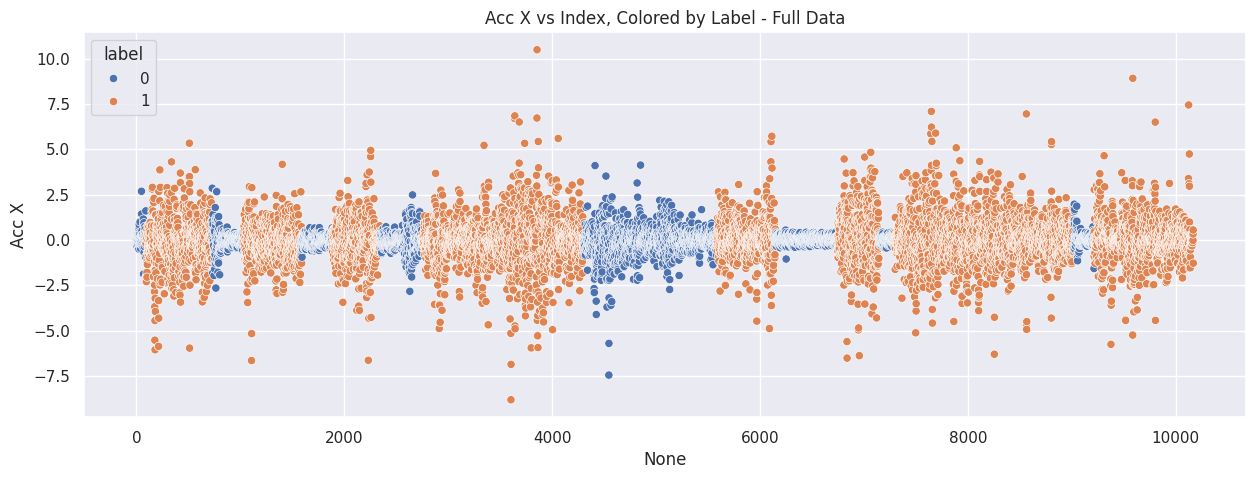

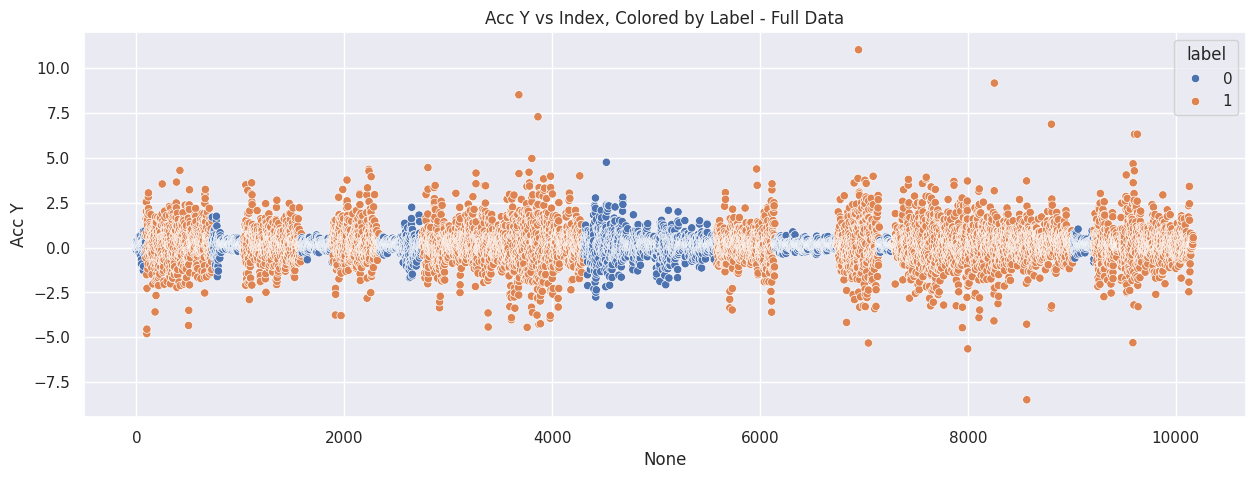

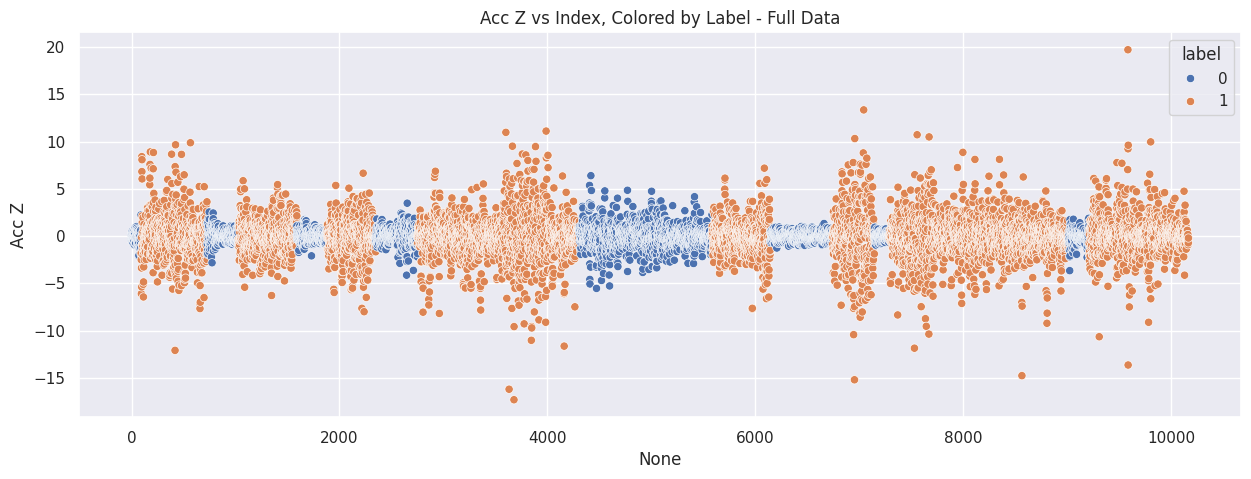

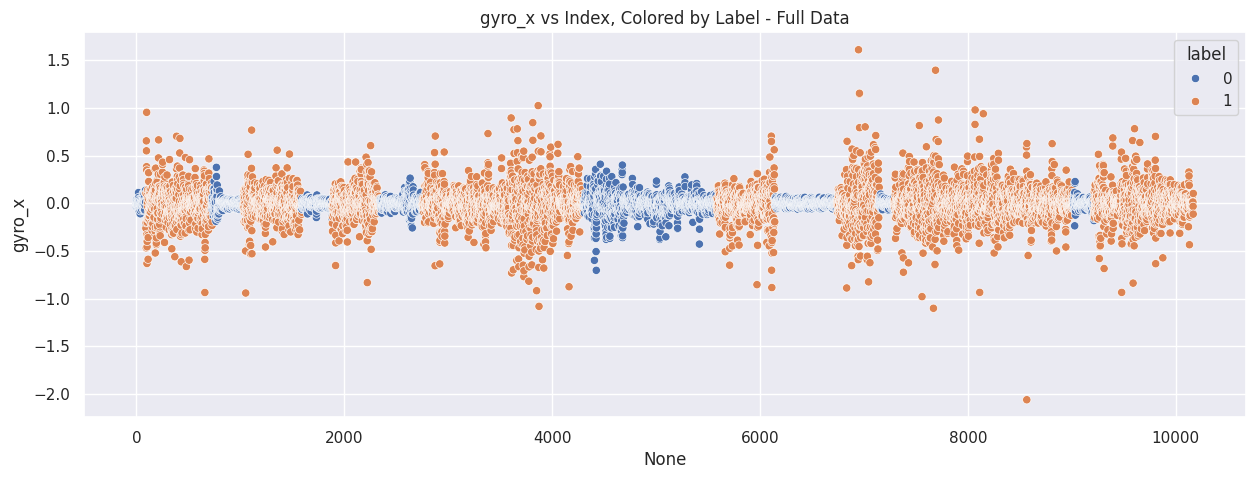

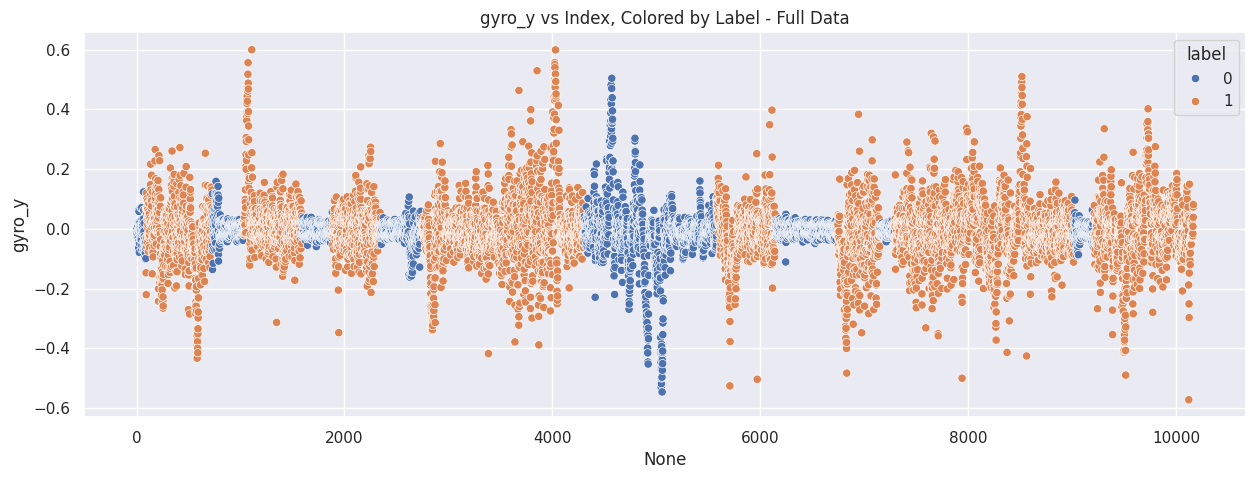

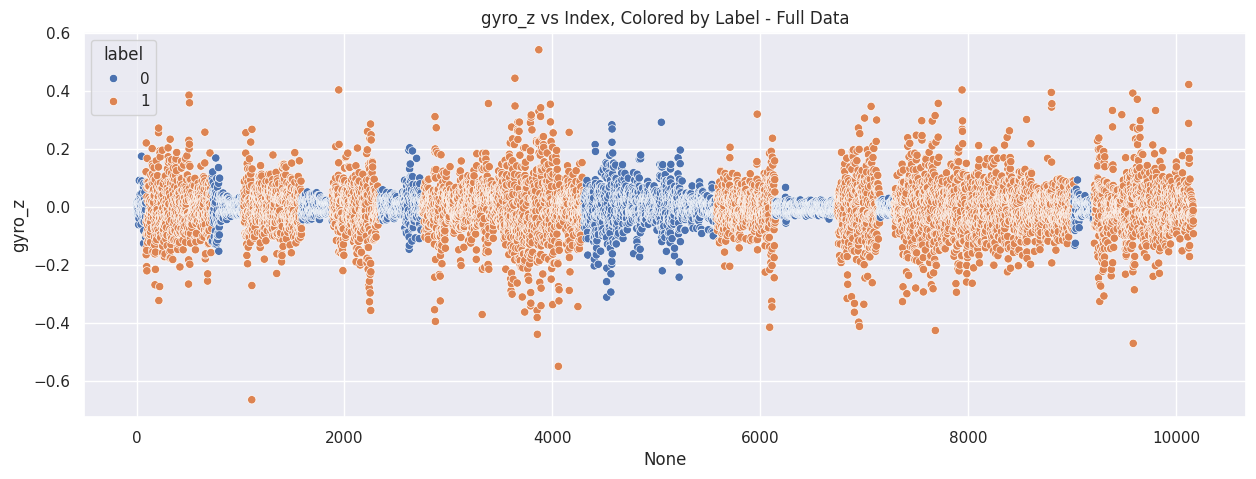

In [ ]:
cols = ['Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z']
for col in cols:
  plt.figure(figsize=(15, 5))
  sns.scatterplot(data=merged_df, x=merged_df.index, y=col, hue='label')
  plt.title(f'{col} vs Index, Colored by Label - Full Data')
  plt.show()

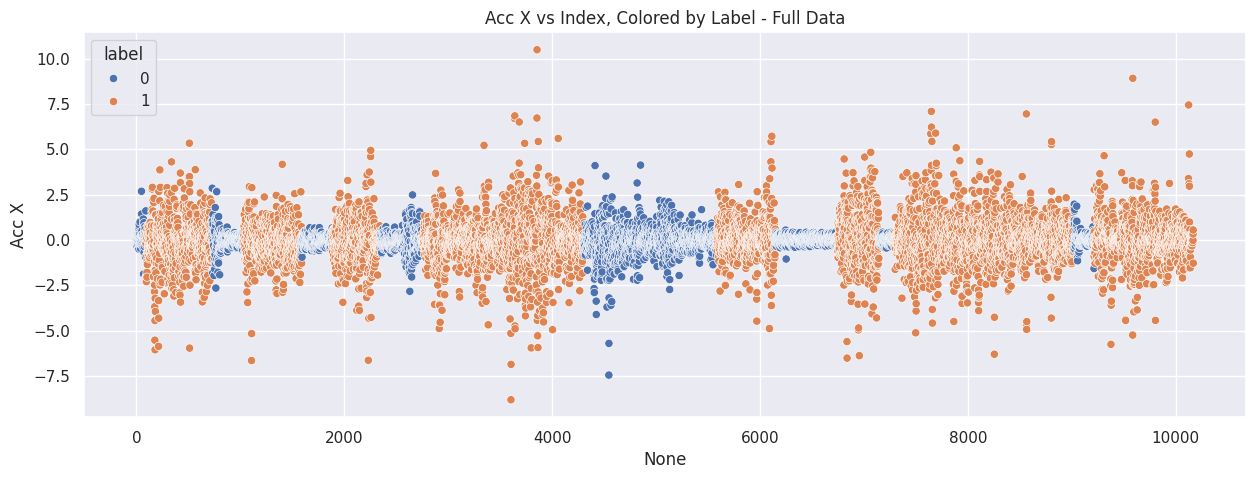

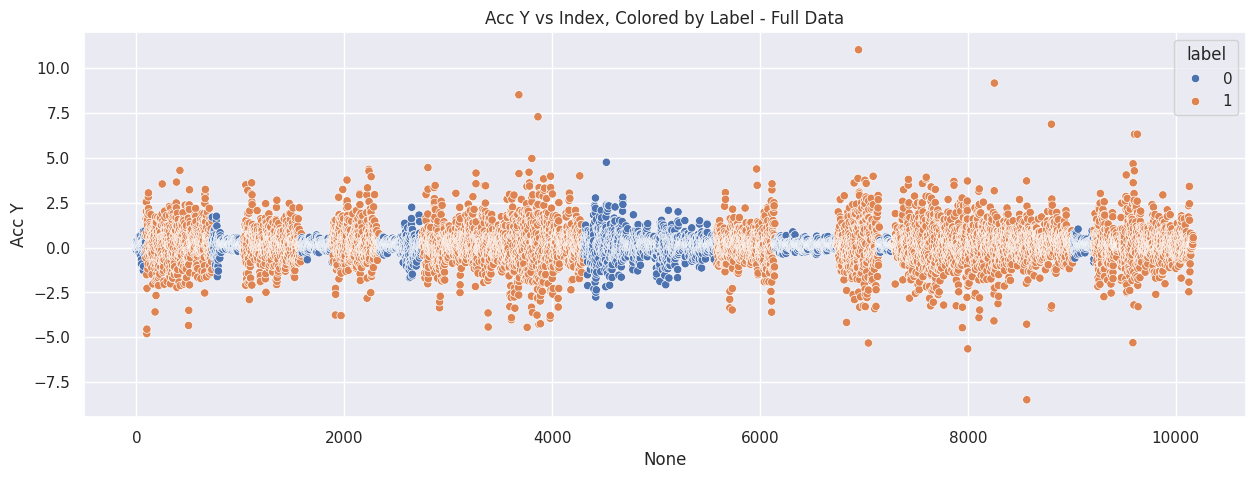

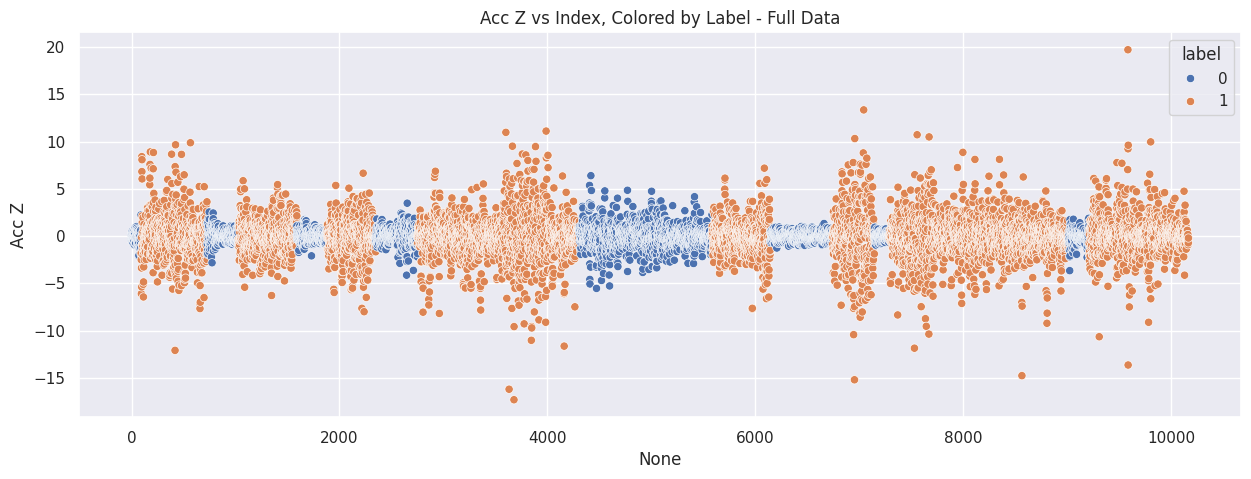

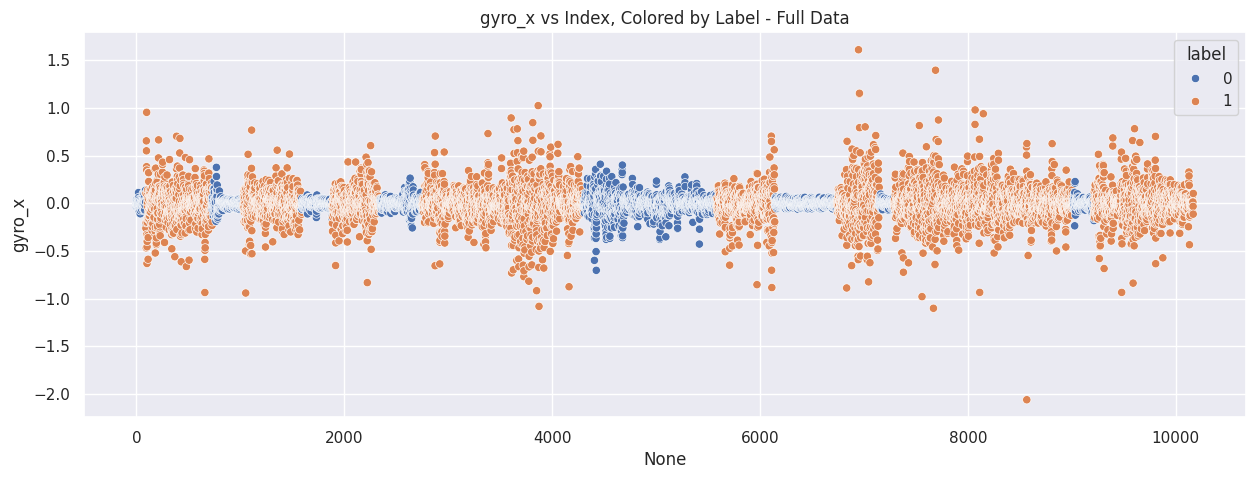

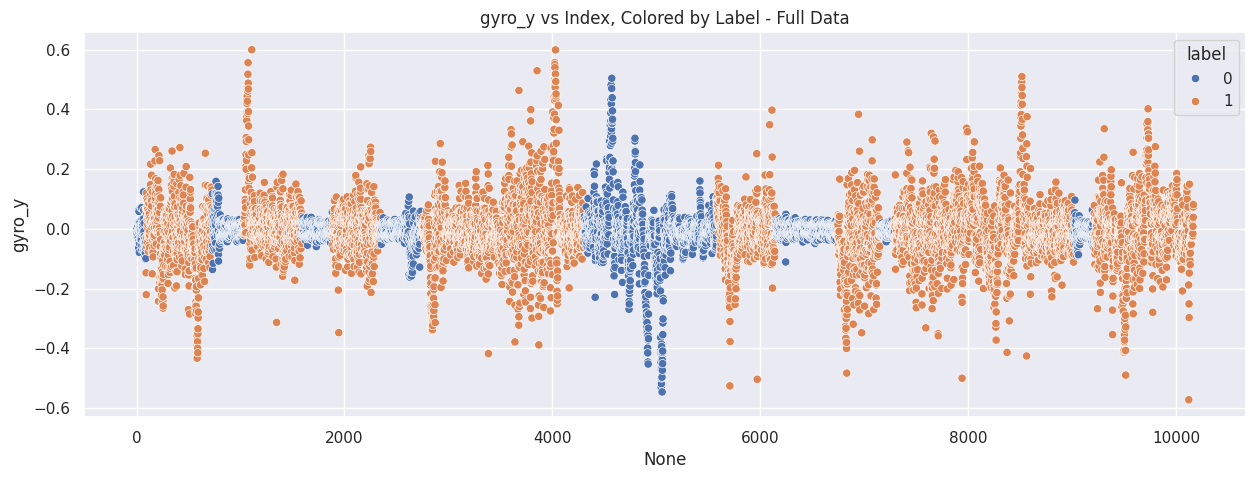

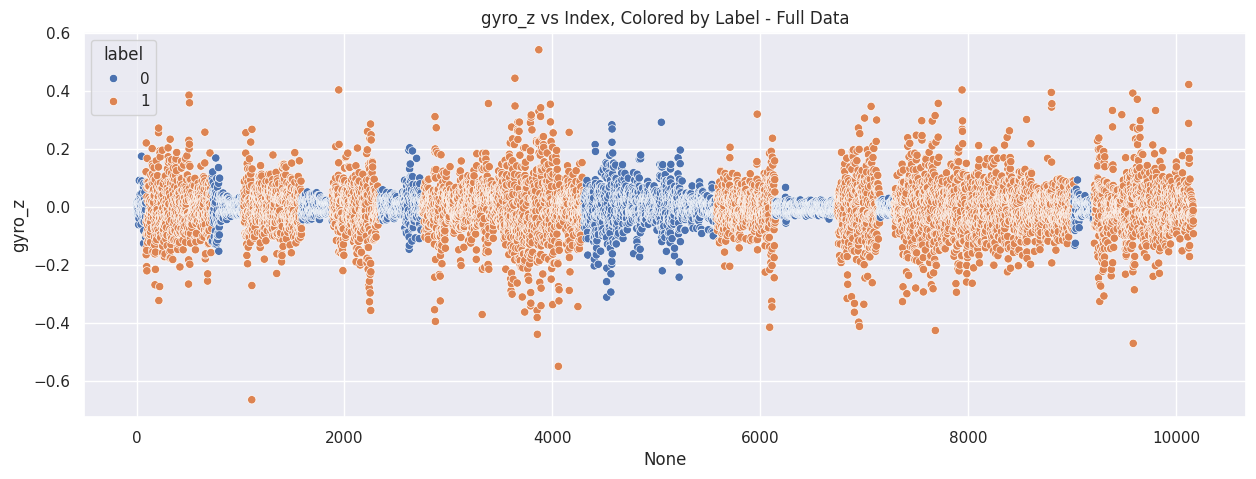

In [ ]:
cols = ['Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z']
for col in cols:
  plt.figure(figsize=(15, 5))
  sns.scatterplot(data=merged_df, x=merged_df.index, y=col, hue='label')
  plt.title(f'{col} vs Index, Colored by Label - Full Data')
  plt.show()

# Feature Extraction / Engineering

## Sliding Window Function for Extracting Features

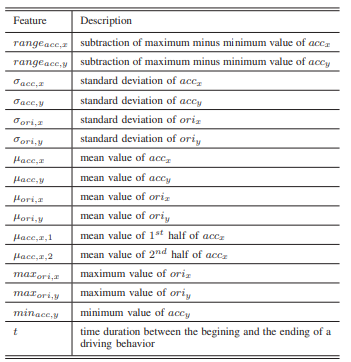

In [ ]:
def compute_rolling_mode(labels, window_size):
    # Convert labels to a DataFrame for vectorized operations
    label_df = pd.DataFrame(labels)
    # Use cumulative sum for 0s and 1s to prepare for differential counting
    cumsum = label_df.cumsum()
    # The shifted cumulative sum gives us the start of the window counts
    shifted_cumsum = cumsum.shift(window_size)
    # The counts within the window are the differences
    window_counts = cumsum - shifted_cumsum.fillna(0)  # Fill NA for the first window
    # Determine the mode (most frequent value) across the window
    # 1 if the count of 1s is greater than half the window size, 0 otherwise
    mode_series = (window_counts >= window_size / 2).astype(int)['label']
    return mode_series

def sliding_window_features_optimized(data, min_t=2, max_t=15, step=1,sample_rate=2):
    sample_rate = sample_rate
    features = []
    numeric_columns = data.select_dtypes(include=[np.number])

    for t in range(min_t, max_t + 1):
        window_size = t * sample_rate # samples per second * window size t
        rolling_windows = numeric_columns.rolling(window=window_size, min_periods=window_size)

        # Compute statistics for each window size
        max_values = rolling_windows.max()
        min_values = rolling_windows.min()
        std_values = rolling_windows.std()
        mean_values = rolling_windows.mean()

        # Calculate mean for first and second halves
        half_window = window_size // 2
        mu_acc_x_1 = numeric_columns['Acc X'].rolling(window=half_window, min_periods=half_window).mean()
        mu_acc_x_2 = numeric_columns['Acc X'].shift(-half_window).rolling(window=half_window, min_periods=half_window).mean()

        # Compute the mode of labels more efficiently
        label_mode = compute_rolling_mode(data['label'], window_size)

        for start in range(window_size - 1, len(data) - window_size + 1, step):
            feature_vector = {
                'time_duration': t,
                'range_acc_x': max_values['Acc X'].iloc[start] - min_values['Acc X'].iloc[start],
                'range_acc_y': max_values['Acc Y'].iloc[start] - min_values['Acc Y'].iloc[start],
                'sigma_acc_x': std_values['Acc X'].iloc[start],
                'sigma_acc_y': std_values['Acc Y'].iloc[start],
                'sigma_ori_x': std_values['gyro_x'].iloc[start],
                'sigma_ori_y': std_values['gyro_y'].iloc[start],
                'mu_acc_x': mean_values['Acc X'].iloc[start],
                'mu_acc_y': mean_values['Acc Y'].iloc[start],
                'mu_ori_x': mean_values['gyro_x'].iloc[start],
                'mu_ori_y': mean_values['gyro_y'].iloc[start],
                'mu_acc_x_1': mu_acc_x_1.iloc[start] if start < len(mu_acc_x_1) else None,
                'mu_acc_x_2': mu_acc_x_2.iloc[start] if start < len(mu_acc_x_2) else None,
                'maxori_x': max_values['gyro_x'].iloc[start],
                'maxori_y': max_values['gyro_y'].iloc[start],
                'minacc_y': min_values['Acc Y'].iloc[start],
                'label': label_mode.iloc[start] if start < len(label_mode) else None,
            }
            features.append(feature_vector)

    return pd.DataFrame(features)


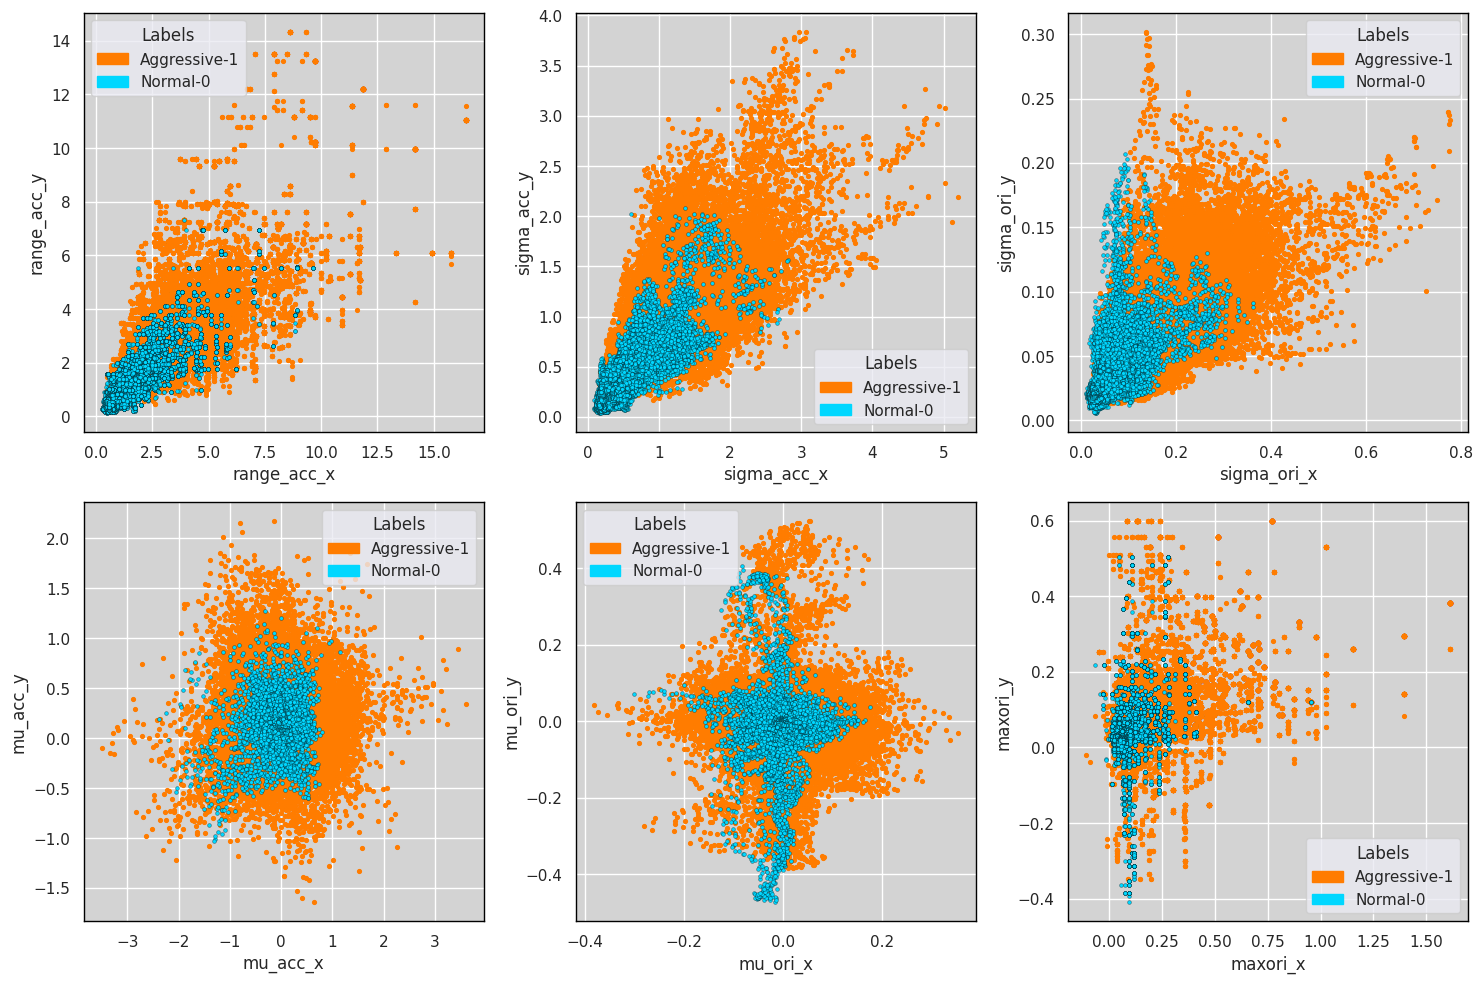

In [ ]:
general_features = sliding_window_features_optimized(merged_df, min_t=5, max_t=10, step=1)
X_general = general_features.drop('label', axis=1)
y_general = general_features['label']
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

#plt.rcParams.update(plt.rcParamsDefault)

columns = ['range_acc', 'sigma_acc', 'sigma_ori', 'mu_acc', 'mu_ori', 'maxori']

# # Create a colormap for red and blue
# cmap = mcolors.ListedColormap(['red', 'blue'])
coolwarm = sns.color_palette("bright", n_colors=10)

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the size as needed

for i, col in enumerate(columns):
    x_col = col + '_x'
    y_col = col + '_y'
    row = i // 3
    col = i % 3

    # Separate the data by label
    data_0 = general_features[general_features['label'] == 0]
    data_1 = general_features[general_features['label'] == 1]

    # Plot the blue samples (label 0) first and then the red samples (label 1)
    axs[row, col].scatter(data_1[x_col], data_1[y_col], color=coolwarm[1], s=7.5)
    axs[row, col].scatter(data_0[x_col], data_0[y_col], color=coolwarm[9], s=7.5, edgecolor='black', linewidth=0.2)

    axs[row, col].set(xlabel=x_col, ylabel=y_col)
    axs[row, col].set_facecolor('lightgray')  # Change the background color to light gray

    # Add grid

    # Create legend
    red_patch = mpatches.Patch(color=coolwarm[1], label='Aggressive-1')
    blue_patch = mpatches.Patch(color=coolwarm[9], label='Normal-0')
    axs[row, col].legend(handles=[red_patch, blue_patch], title="Labels")

    # legend1 = axs[row, col].legend(*scatter.legend_elements(), title="Labels")
    # axs[row, col].add_artist(legend1)

    for _, spine in axs[row, col].spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)

# Display the plot
plt.tight_layout()
plt.show()

# Train / Test Split (for Time Series)



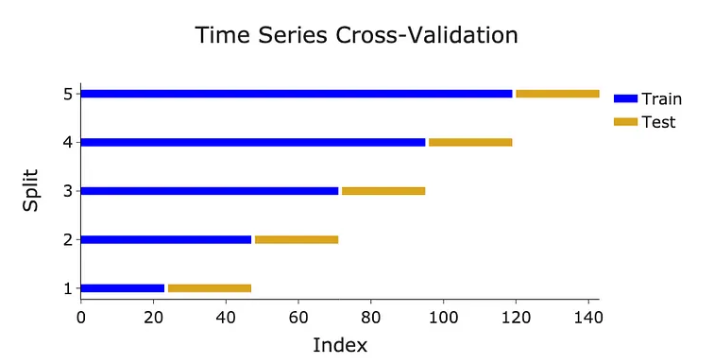

In [ ]:
# Import packages
import plotly.graph_objects as go # TODO - Rewrite without using GO
import pandas as pd
from sklearn.model_selection import KFold


def plot_cross_val(n_splits: int,splitter_func,df: pd.DataFrame,title_text: str) -> None:
    """Function to plot the cross validation of various
    sklearn splitter objects."""

    split = 1
    plot_data = []

    for train_index, valid_index in splitter_func(n_splits=n_splits).split(df):
        plot_data.append([train_index, 'Train', f'{split}'])
        plot_data.append([valid_index, 'Test', f'{split}'])
        split += 1

    plot_df = pd.DataFrame(plot_data,columns=['Index', 'Dataset', 'Split']).explode('Index')

    fig = go.Figure()
    for _, group in plot_df.groupby('Split'):
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Train'],
                                 y=group['Split'].loc[group['Dataset'] == 'Train'],
                                 name='Train',
                                 line=dict(color="blue", width=10)
                                 ))
        fig.add_trace(go.Scatter(x=group['Index'].loc[group['Dataset'] == 'Test'],
                                 y=group['Split'].loc[group['Dataset'] == 'Test'],
                                 name='Test',
                                 line=dict(color="goldenrod", width=10)
                                 ))

    fig.update_layout(template="simple_white", font=dict(size=20),
                      title_text=title_text, title_x=0.5, width=850,
                      height=250, xaxis_title='Index', yaxis_title='Split')

    legend_names = set()
    fig.for_each_trace(
        lambda trace:
        trace.update(showlegend=False)
        if (trace.name in legend_names) else legend_names.add(trace.name))

    return fig.show()

# Import packages
from sklearn.model_selection import TimeSeriesSplit

# Plot the time series cross validation splits
plot_cross_val(n_splits=2,splitter_func=TimeSeriesSplit,df=merged_df,title_text=f'Time Series Cross-Validation Illustration - {2} Splits')
plot_cross_val(n_splits=3,splitter_func=TimeSeriesSplit,df=merged_df,title_text=f'{3} Splits')
plot_cross_val(n_splits=5,splitter_func=TimeSeriesSplit,df=merged_df,title_text=f'{5} Splits')

# Selecting Best Model and Hyperparameters

In [ ]:
from sklearn.preprocessing import LabelEncoder
def get_class_weights(y):
  # Label encode the target variable
  le = LabelEncoder()
  y_train_encoded = le.fit_transform(y)
  # Calculate class weights
  class_weights = dict(zip(np.unique(y_train_encoded),np.bincount(y_train_encoded) / len(y_train_encoded)))
  return class_weights

class_weights = get_class_weights(merged_df['label'])
print("class_weights: ",class_weights)


class_weights:  {0: 0.32451568492477134, 1: 0.6754843150752287}


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.svm import LinearSVC, SVC
import joblib
import time
import os
from sklearn.metrics import classification_report, matthews_corrcoef

# Define the models you want to test
models = {
    'Linear SVM': LinearSVC(),
    'Linear SVM Weight Balanced': LinearSVC(class_weight=class_weights,max_iter=2000,C=0.01),
    'RBF Kernel SVM': SVC(kernel='rbf',probability=True),
    'RBF Kernel SVM Class Weight Balanced': SVC(kernel='rbf',probability=True,class_weight=class_weights),
    'Polynomial Kernel SVM': SVC(kernel='poly',probability=True,),
    'Polynomial Kernel SVM Weight Balanced': SVC(kernel='poly',probability=True,class_weight=class_weights),
    'Sigmoid Kernel SVM': SVC(kernel='sigmoid',probability=True,),
    'Sigmoid Kernel SVM Weight Balanced': SVC(kernel='sigmoid',probability=True,class_weight=class_weights),
}
# make a predictions dict
preds_dict = models.copy()
for key, _ in preds_dict.items():
  preds_dict[key] = np.nan

In [ ]:
step=1
min_t=2
max_t=7
data = sliding_window_features_optimized(merged_df, min_t=min_t, max_t=max_t, step=step)

# split to features and label
X = data.drop('label', axis=1)
y = data['label']

# prompt: Split X and y by index 0.7 of length
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

# scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Dictionary to hold evaluation results
results = []
roc_data = []
# Define the directory path where the model will be saved
directory = f'/content/drive/MyDrive/Models/{time.time()}'
# Create the directory if it does not exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Evaluate each model
for name, model in models.items():
    print("Training ",name)
    start_time = time.time()  # Start timing
    model.fit(X_train_scaled, y_train)  # Train the model
    end_time = time.time()  # End timing
    training_time = round(end_time - start_time,3)  # Calculate training time
    print(f"Done after {training_time:.2f} seconds")

    # Save the model to the newly created directory
    model_path = os.path.join(directory, f'{model}.pkl')
    # Save the model to a file
    joblib.dump(model, model_path)

    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else None # hasattr is something new I learned in this project!
    preds_dict[name] = y_pred

    # Evaluate the model
    acc = round(accuracy_score(y_test, y_pred),3)
    auc_score = round(roc_auc_score(y_test, y_prob[:, 1]),3) if y_prob is not None else None
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()
    mcc =  matthews_corrcoef(y_test, y_pred)

    # Store results
    results.append({
        'Model Name': name,'MCC':mcc,'Accuracy': acc,'Auc-Roc': auc_score,
        'TP': tp,'FP': fp,'TN': tn,'FN': fn,
        'train_time_secs': training_time})

    # Store data for summary ROC plot
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_data.append((fpr, tpr, roc_auc, name))

# Create DataFrame from results
results_df = pd.DataFrame(results).sort_values(by='MCC', ascending=False)

# Display the DataFrame
display(results_df)
best_model_name = results_df.loc[results_df['MCC'].idxmax()]['Model Name']
best_model = models[best_model_name]



Training  Linear SVM


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Done after 6.48 seconds
Training  Linear SVM Weight Balanced
Done after 0.19 seconds
Training  RBF Kernel SVM
Done after 271.53 seconds
Training  RBF Kernel SVM Class Weight Balanced
Done after 291.89 seconds
Training  Polynomial Kernel SVM
Done after 282.64 seconds
Training  Polynomial Kernel SVM Weight Balanced
Done after 336.20 seconds
Training  Sigmoid Kernel SVM
Done after 236.22 seconds
Training  Sigmoid Kernel SVM Weight Balanced
Done after 231.66 seconds


Model Name       MCC  Accuracy  Auc-Roc    TP  \
2                         RBF Kernel SVM  0.702806     0.873    0.933  4062   
4                  Polynomial Kernel SVM  0.680089     0.863    0.911  3784   
3   RBF Kernel SVM Class Weight Balanced  0.660421     0.853    0.914  3426   
1             Linear SVM Weight Balanced  0.649615     0.852      NaN  3978   
5  Polynomial Kernel SVM Weight Balanced  0.648664     0.848    0.895  3326   
0                             Linear SVM  0.607589     0.826      NaN  4467   
7     Sigmoid Kernel SVM Weight Balanced  0.597455     0.830    0.820  3725   
6                     Sigmoid Kernel SVM  0.547395     0.805    0.795  3929   

     FP     TN    FN  train_time_secs  
2   485  11897  1832          271.530  
4   388  11994  2110          282.643  
3   212  12170  2468          291.895  
1   797  11585  1916            0.193  
5   204  12178  2568          336.197  
0  1757  10625  1427            6.483  
7   930  11452  2169          231.656  
6  1595  10787  1965          236.225

AUC-ROC plot

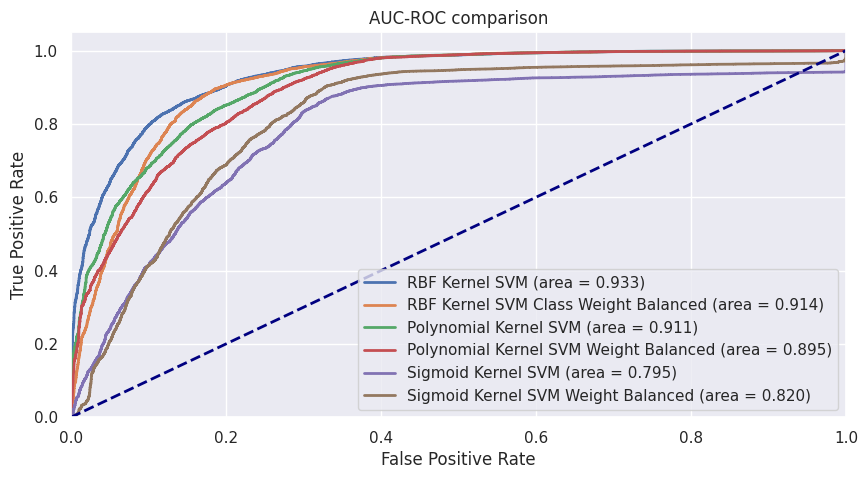

In [ ]:
sns.set_theme(style="darkgrid", rc={ 'figure.figsize': (10, 5)})
# Plot summary of ROC Curves
# plt.figure(figsize=(6, 5))
for fpr, tpr, roc_auc, name in roc_data:
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC comparison')
plt.legend(loc="lower right")
plt.show()

Confusion matrix of best model

Text(0.5, 1.0, 'Confusion Matrix for RBF Kernel SVM')

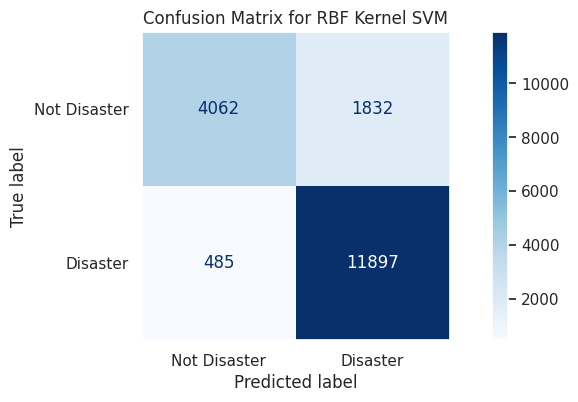

In [ ]:
# prompt: plot confusion matrix based on confusion_matrix(y_test, y_pred), title: title(f'Confusion Matrix for {best_model_name}')
sns.set_theme(style="dark", rc={ 'figure.figsize': (11, 4)})
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels=['Normal', 'Aggressive'],cmap=plt.cm.Blues)ף
disp.ax_.set_title(f'Confusion Matrix for {best_model_name}');

## Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
X_scaled = scaler.fit_transform(X)
scores = cross_val_score(best_model, X_scaled, y, cv=5)
print(f"Cross-validation scores for the best model ({best_model_name}): {scores}")
print(f"Average cross-validation score: {scores.mean()}")

Cross-validation scores for the best model (RBF Kernel SVM): [0.86572554 0.85809258 0.86252462 0.89460724 0.89871132]
Average cross-validation score: 0.875932260646071


### Time Series cross validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import StandardScaler

# Scale your data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)
# Create a scorer for MCC
mcc_scorer = make_scorer(matthews_corrcoef)
# Perform cross-validation
scores = cross_val_score(best_model, X_scaled, y, cv=tscv, scoring=mcc_scorer)
print(f"Cross-validation scores for the best model ({best_model_name}): {scores}")
print(f"Average cross-validation score: {scores.mean()}")

Cross-validation scores for the best model (RBF Kernel SVM): [0.66356187 0.69121204 0.70372271 0.72570673 0.73494214]
Average cross-validation score: 0.703829098654442
